# Week 8 section

In this notebook, we cover:
1. Hopfield networks, which we didn't get to discuss much in class. This is one option for you for implementing w08 homework.

2. The other option is to build a feedforward one-neuron network to distinguish between two classes of letters. We go over this as well.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 1) Hopfield networks

For this week's homework one option is to implement a Hopfield network that can hopefully distinguish letters.

### Data

In [ ]:
letters_url = ["http://mcb111.org/w08/abc.A.cat","http://mcb111.org/w08/abc.B.cat",
               "http://mcb111.org/w08/abc.C.cat","http://mcb111.org/w08/abc.D.cat",
               "http://mcb111.org/w08/abc.E.cat","http://mcb111.org/w08/abc.X.cat",
               "http://mcb111.org/w08/abc.Z.cat"]

handwritten_letters_url = ["http://mcb111.org/w08/abc.pmin0.3.pmax0.5.A.dat","http://mcb111.org/w08/abc.pmin0.3.pmax0.5.B.dat",
                           "http://mcb111.org/w08/abc.pmin0.3.pmax0.5.C.dat","http://mcb111.org/w08/abc.pmin0.3.pmax0.5.D.dat",
                           "http://mcb111.org/w08/abc.pmin0.3.pmax0.5.E.dat","http://mcb111.org/w08/abc.pmin0.3.pmax0.5.X.dat",
                           "http://mcb111.org/w08/abc.pmin0.3.pmax0.5.Z.dat"]

In a similar fashion of what we've done in previous weeks we are going to define a function that can read these letters from the url. We know that these letters are going to be 5x5 grids populated with certain characters, and we might have more than one example of the letter at each url:

In [ ]:
def load_letter(url):
    '''
    This function helps us load the data from the hand-written letters.
    input = url with data.
    output = array with each letter in a 5x5 array format.

    1st line uses np.loadtxt to load the data line by line into an array
    2nd line transforms those into 1 item per pixel
    3rd line transforms x's and dots into -1's and 1's see the documentatin of np.where to learn more!
    4th line reshapes the array into an array of 5 by 5 images of the handwritten data
    '''
    dat = np.loadtxt(url, dtype = 'str')
    dat = np.array([list(row) for row in dat])
    dat = np.where(dat =='.' , -1 ,1)
    dat = dat.reshape(len(dat.flatten())//(5*5),5,5)
    return dat

let's test it and see how we can visualize these letters:

In [ ]:
reference_A = load_letter(letters_url[0])
reference_A.shape

(18, 5, 5)

There seem to be 10 examples of letter A in this data:

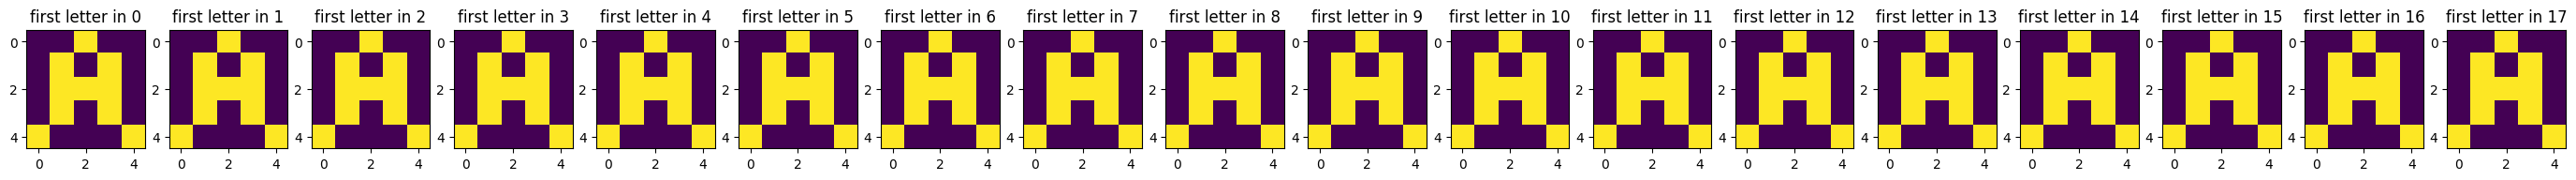

In [ ]:
fig,ax = plt.subplots(ncols= reference_A.shape[0], nrows = 1, sharex = True)
fig.set_figwidth(35)
fig.set_figheight(5)

axs = ax.flatten()

for ax,idx in zip(axs, range(len(reference_A))):

    ax.imshow(reference_A[idx])
    ax.set_title("first letter in {}".format(idx))

What about at the handwritten examples for letter A

In [ ]:
hand_A = load_letter(handwritten_letters_url[0])
hand_A.shape

(2000, 5, 5)

There seems to be 2000 examples of the handwritten character A, let's only look at a few of them:

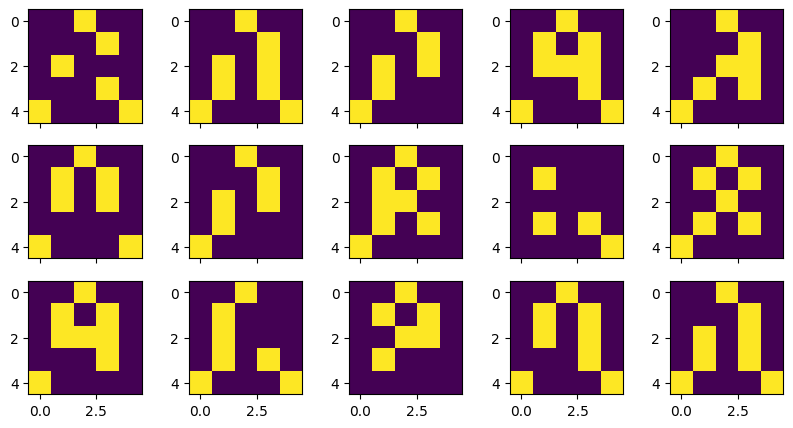

In [ ]:
fig,ax = plt.subplots(ncols = 5, nrows = 3, sharex = True)
fig.set_figwidth(10)
fig.set_figheight(5)

axs = ax.flatten()

for ax,idx in zip(axs, range(len(hand_A[:5*3]))):

    ax.imshow(hand_A[idx])

The handwritten aren't perfect like the reference, but we will implement the hopfield network and see how many of them can be recognized as A's.

How do we implement the hopfield network?

From mackay's book:

*In this chapter we will discuss a fully connected feedback network called
the Hopfield network. The weights in the Hopfield network are constrained to
be symmetric, i.e., the weight from neuron i to neuron j is equal to the weight
from neuron j to neuron i.*

*Hopfield networks have two applications. First, they can act as associative
memories.*

Then it goes to describe hebbian learning, in a way that is very intuitive. I recommend if you can that you read  Mackay's section 42.1 if you are struggling to understand what's going on conceptually.

However, let's break down a couple of things that you are going to want to be able to do in order to implement the weight matrix.


### The weight matrix

Hopfield networks are comprised of fully connected neurons. That means every neuron is connected to their neighbours and vice-versa. These connections describe the flow of information through the network using **weights**. Since the hopfield networks have the property of such connections being bidirectional in the **weight matrix** position (1,2) and (2,1), which hold the **weights** for the connections between neuron 1 and 2 have the same value. In other words:

$$w_{n,m} = w_{m,n}$$

And the neurons do not have a self connection. the weight for a connection between a neuron and itself is zero, in other words:

$$w_{n,n} = 0 $$

This already gives us a pretty good idea of what such a weight matrix has to look like: zeros on the main diagonal and symmetric along that axis.

Now we want to decode our 5 by 5 image into a format that can be uptaken by the network we are building, by linearizing the array in which we are storing the information using the `np.flatten()` method we can achieve this, for example:

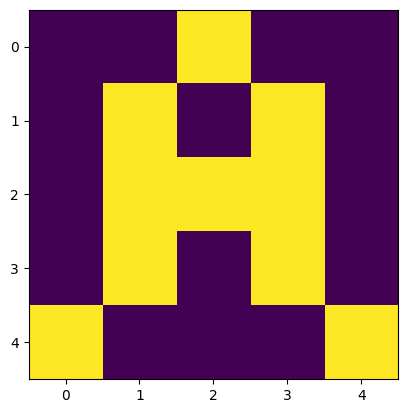

In [ ]:
plt.imshow(reference_A[0])

In [ ]:
reference_A[0].flatten()

array([-1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1,  1, -1, -1, -1,  1])

Notice that this is just a 1 dimensional representation of the same image, simply we add the first row, then the second and so on.

Given a 25-dimensional input vector $y$, and the 25$\times$25 dimensional weight matrix $w$, then the activation $a$ of the $n$th neuron, $a_n$, is

$$\begin{aligned}
a_n &= \sum_{m=1}^{25} w_{nm} y_m  \\
&= w_{n,1} y_1 + w_{n,2} y_2 + \dots + w_{n,25} y_{25}
\end{aligned}$$

Let's say we trained our connectivity matrix by storing a perfect A. As seen in the lecture notes, the first row of $w$ is

`0  1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1  1  1 -1 `

Now let's say we provide as input to the network a perfect A -- we better get a perfect A as the output of the network!

Let's just focus on the first row of our 5$\times$5 digit representation. Our perfect A input is $y = [-1, -1, +1, -1, -1, \dots ]$.

To get a perfect A output, then we need basically this same vector -- first pixel needs to be off, as does the second pixel, then the third pixel needs to be on, then pixels 4 and 5 need to be off.

Let's look at the output of the network when providing the above $y$ as input.

$$\begin{aligned}
a_1 &= w_{1,1} y_1 + w_{1,2} y_2 + \dots + w_{1,25} y_{25} \\
&= 0(-1) +1(-1) -1(+1) +1(-1) +1(-1) + \dots \\
&= -24
\end{aligned}$$

(Ignoring the first position because neuron 1 can't talk to itself), every single time that $y$ has a positive 1 in an entry, the connectivity matrix entry is a negative 1, and vice versa. This makes sense -- if we want a perfect A as an output, we need the first pixel to be off. By storing the perfect A into the network, then we've encoded the information that when the first pixel is off, so is the second pixel, and pixels 4 and 5, but pixel 3 is on. The result of the above operation makes a very negative number -- that is the **activation** $a_n$. We get an **activity** $y_n$ via

$$y(a) = \left\{\begin{matrix}
+1 & a \geq 0\\
-1 & a < 0\\
\end{matrix}
\right.$$


This is where `np.where()` might come in handy, to scan a vector for a condition, for example its numbers being higher than 0 and replacing it's value for 1 or -1. we use this function above in the load_letter function.


So by this rule, $y_1 = y(a_1) = y(-24) = -1$.

Now, what if we passed in a slightly corrupted version of an A? Again let's just restrict ourselves to the top row of the image. Say that we had the second pixel on, when ideally it should be off: $y_{corrupt} = [-1, +1, +1, -1, -1, \dots ]$.

$$\begin{aligned}
a_1 &= w_{1,1} y_{corrupt, 1} + w_{1,2} y_{corrupt, 2} + \dots + w_{1,25} y_{corrupt, 25} \\
&= 0(-1) +1(+1) -1(+1) +1(-1) +1(-1) + \dots \\
&= -22
\end{aligned}$$

A-ha: we have a single mismatch at the second index, contributing a $+1$ to our summation. But there are so many matches at all the other pixels that the activation is still very negative, so the activity $y_1$ after passing in the imperfect A is still $-1$ and the pixel is off.

This is the fundamental property of the Hopfield network -- by storing patterns and the pairwise interactions between pixels, then imperfect versions of the patterns that get passed in to the network can get "corrected" by all the stored pairwise information between pixels -- you just need enough pixels to be on when they should be on, and off when they should be off, to fix imperfect patterns.

### But how do we actually set the weights?

For that we are going to use Hebb's rule, we are going to create a matrix of the appropriate size and populate it according to this rule, this is the form of the rule for a single pattern:

$$w_{nm} = y_n y_m$$

Let's say we wanted to add the memory A to the network, here we show how the first row would look like:


In [ ]:
w = np.zeros((25,25))
memory = reference_A[0].flatten()

w[0, 0] += 0
w[0, 1] += (memory[0]*memory[1])
w[0, 2] += (memory[0]*memory[2])
w[0, 3] += (memory[0]*memory[3])
w[0, 4] += (memory[0]*memory[4])
w[0, 5] += (memory[0]*memory[5])
w[0, 6] += (memory[0]*memory[6])
w[0, 7] += (memory[0]*memory[7])
w[0, 8] += (memory[0]*memory[8])
w[0, 9] += (memory[0]*memory[9])
w[0, 10] += (memory[0]*memory[10])
w[0, 11] += (memory[0]*memory[11])
w[0, 12] += (memory[0]*memory[12])
w[0, 13] += (memory[0]*memory[13])
w[0, 14] += (memory[0]*memory[14])
w[0, 15] += (memory[0]*memory[15])
w[0, 16] += (memory[0]*memory[16])
w[0, 17] += (memory[0]*memory[17])
w[0, 18] += (memory[0]*memory[18])
w[0, 19] += (memory[0]*memory[19])
w[0, 20] += (memory[0]*memory[20])
w[0, 21] += (memory[0]*memory[21])
w[0, 22] += (memory[0]*memory[22])
w[0, 23] += (memory[0]*memory[23])
w[0, 24] += (memory[0]*memory[24])

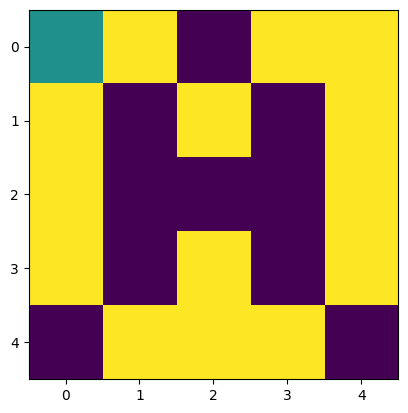

In [ ]:
plt.imshow(w[0].reshape(5,5))

In [ ]:
w = np.zeros((25,25))
memory = reference_A[1].flatten()

w[0, 0] += 0
w[0, 1] += (memory[0]*memory[1])
w[0, 2] += (memory[0]*memory[2])
w[0, 3] += (memory[0]*memory[3])
w[0, 4] += (memory[0]*memory[4])
w[0, 5] += (memory[0]*memory[5])
w[0, 6] += (memory[0]*memory[6])
w[0, 7] += (memory[0]*memory[7])
w[0, 8] += (memory[0]*memory[8])
w[0, 9] += (memory[0]*memory[9])
w[0, 10] += (memory[0]*memory[10])
w[0, 11] += (memory[0]*memory[11])
w[0, 12] += (memory[0]*memory[12])
w[0, 13] += (memory[0]*memory[13])
w[0, 14] += (memory[0]*memory[14])
w[0, 15] += (memory[0]*memory[15])
w[0, 16] += (memory[0]*memory[16])
w[0, 17] += (memory[0]*memory[17])
w[0, 18] += (memory[0]*memory[18])
w[0, 19] += (memory[0]*memory[19])
w[0, 20] += (memory[0]*memory[20])
w[0, 21] += (memory[0]*memory[21])
w[0, 22] += (memory[0]*memory[22])
w[0, 23] += (memory[0]*memory[23])
w[0, 24] += (memory[0]*memory[24])

print(w[0])

[ 0.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.
 -1.  1. -1.  1.  1.  1. -1.]


### Using matrices to speed this up:

In [ ]:
# take the outer product of the neurons to get the weight matrix
w = np.outer(memory,memory)

# set self-interaction terms to zero
w = w * (1 - np.eye(len(memory)))

# check that our method is the same as the previous
print(w.shape)

(25, 25)


### Remembering many patterns

If you wanted to store $k$ patterns, you add average product at the $n$ and $m$ entries for each pattern:

$$w_{nm} = \frac{ (y^1_{n} y^1_{m}) +(y^2_{n} y^2_{m}) + \dots + (y^k_{n} y^k_{m})}{k}$$

$$w_{nm} = \frac{1}{k} \sum_{k=1}^K y_n^{(k)} y_m^{(k)}.$$

In your own implementation, it would be tedious writing the above out by hand -- think about how you could use a for loop to build the weight matrix instead.

In [ ]:
np.shape(reference_A)

(10, 5, 5)

In [ ]:
# # some skeleton code to help you with your hopfield network!
# patterns = reference_A.copy()

def train(patterns):
  # for pattern in patterns:
  # train the weights specific to each pattern!
  return weights

# weights = train(patterns)

def recall(weights, query, max_steps = 1):
  # for in range(max_steps):
    # update the query by running it through the network!

  return query # now updated!

# a little helper function to plot flattened letters -- use at own risk!
def show_letter(letter_vec):
    # reshape the array into a 5x5 matrix
    array_2d = letter_vec.reshape((5, 5))

    # display the 5x5 matrix using imshow
    plt.imshow(array_2d)
    plt.show()

## 2) Feedforward neuron model

- Choose two letters -- say A and B, or some other pair, and collect all of the imperfect As and Bs -- let's call this your data $X$, and their labels $t$ (whether each imperfect letter is an A or a B -- you need to pick one letter to be +1 and the other to be -1).
- It is good practice to split up your data into a training set, which you use to train a model like your one-neuron network, and then a testing set, so that you can evaluate the model's performance on unseen data.
- To do this, if you have 2000 examples of A and 2000 examples of B, it would be good to randomize the order of the data. If $N=4000$ (the total number of examples, both As and Bs), then you can get a random ordering via `np.random.choice(np.arange(N), N, replace=False)`. Then, set some number of training points `N_train`, and use `X_train = X_shuffled[:N_train]` as your training examples. Here's an example of making a random shuffling:

In [ ]:
N = 5
# sample array of N indices, without replacement
random_shuffling = np.random.choice(np.arange(N), N, replace=False)
print(random_shuffling)
# Then, you can shuffle X via X_shuffled=X[random_shuffling]
# And you definitely want to use the same shuffling for T, so that
# you keep the same associations between letters and their labels
# T_shuffled = T[random_shuffling]

[3 2 0 4 1]


- The neuron model actually has 26 parameters -- the activation $a$ is $w_0 + w_1 x_1 + \dots w_{25} x_{25}$. The easiest way to implement this is to add a column of 1s to your $X$ data (think of it as a hidden $x_0=1$ that gets multiplied by $w_0$). Here's how you can append a column of 1s to an array:


In [ ]:
N = 3
# make an example array
X = np.arange(N**2+N).reshape((N, N+1))
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [ ]:
# just np.ones(N) gives you an array of N ones, with shape (N,)
# the [:, np.newaxis] converts that array
# into a column vector, with shape (N,1)
ones = np.ones(N)[:, np.newaxis]
ones

array([[1.],
       [1.],
       [1.]])

In [ ]:
# "horizontal stack" the column vector onto X:
np.hstack((ones, X))

array([[ 1.,  0.,  1.,  2.,  3.],
       [ 1.,  4.,  5.,  6.,  7.],
       [ 1.,  8.,  9., 10., 11.]])

- The key thing to implement is the update of the weight vector
  - If you use stochastic gradient descent, then in each step of training, you
   - pick a random data point, $X^{(m)}$,
   - predict its label via the current state of the model, $y^{(m)} = \frac{1}{1+e^{-\sum_j w_{old, j} X^{(m)}_j }}$,
   - then get its true label $t^{(m)}$, and
   - update your weights via $w_{new} = w_{old} + \eta (t^{(m)} - y^{(m)}) X^{(m)}$
  - If you use batch gradient descent, then in each step of training you pass through the entire dataset, so each weight update uses all of the data: $w_{new} = w_{old} + \eta \sum_n (t^{(n)} - y^{(n)}) X^{(n)}$
- It would be good to compare what the results look like with stochastic gradient descent and the batch version -- which method takes longer to run? By how much?
- When just starting out, it could be good to set some reasonable max number of steps that you know won't take too long to wait, just to get a sense of the performance of the model. After that, think about convergence conditions (the loss function, the weights, etc.)

In [ ]:
# some optional helper functions to get you on your way
# activation function - we choose a logistic sigmoid
def sigmoid(z):
    return # what's the form of a sigmoid (logistic function) ?

def predict(X, weights):
    return # how do we compute the current predictions?

def compute_loss(X, y, weights, alpha = 0):
  # compute a prediction
  # compute the log likelihood loss
    # note that you might want to pad your logs with a small pseudocount eps to avoid blowup
      eps = 1e-15
  # compute the regularization term (with alpha!)
  return log_lik + reg_term

def compute_gradient(X, y, weights, alpha=0):
  return # how do we compute the gradient of the loss?

def update_weights(weights, gradient, eta):
    return # once we've computed the gradient, how do we update our model weights?

In [ ]:
# set iteration steps/learning rate/regularization parameters
# found after manual exploration until convergence
n_steps = #?
eta = #?
alpha = #?

# initialize weights as random
ws = #? whats the dimension?

# what else do we need to keep track of?
all_pred_ys = [] #predictions
losses = [] #losses

# loop through train steps
for s in range(1, n_steps):

    # current weights
    cur_w = #?
    next_w = #?

    loss = 0
    pred_ys = []

    # stochastic gradient descent
    if do_SGD:

        # 1) pick a point at random, retrieve its letter and true label
        m = #?
        Xm = #?
        tm = #?

        # 2) get predicted label
        pred_y = #?

        # 3) update weights
        next_w += #?
        pred_ys.append(pred_y)

        # 4) update loss
        loss -= #?

    # batch gradient descent
    else:

        # go through all data points
        for n in range(N_train):
            # 1) get data point and true label
            Xn = #?
            tn = #?

            # 2) get predicted label
            pred_y = #?

            # 3) update weights
            next_w += #?
            pred_ys.append(pred_y)

            # 4) update loss
            loss -= #?

    all_pred_ys.append(pred_ys)
    losses.append(loss)

    # fill in next weight
    ws[?, ?] = next_w #what indices?

all_pred_ys = np.array(all_pred_ys)
losses = np.array(losses)

- KEY: look at the resultant weights of the network!!! Especially of the neurons representing pixels of the letters (i.e. not $w_0$, the bias). Here's one way to link the 25 weights back to our 5x5 representation:

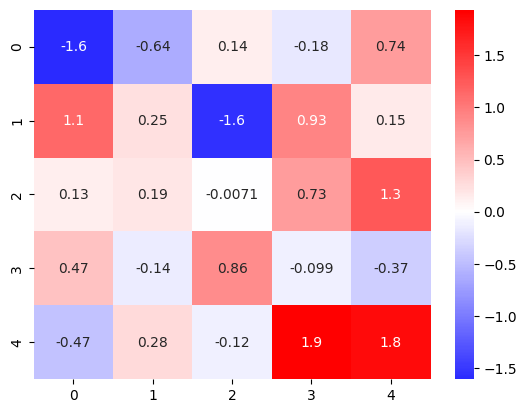

In [ ]:
# make random weights corresponding to 25 pixels, reshape to 5x5
w = np.random.normal(0, 1, 25).reshape((5,5))

# make a heatmap, positive weights are red, negative weights are blue
import seaborn as sns
plt.figure()
sns.heatmap(w, annot=True, cmap='bwr', center=0)
plt.show()

- The weights in the one-neuron model have a direct interpretation. Let's say you said that letter A is "+1" and letter B is "-1", and you want to know whether a particular corrupted letter is more likely to be an A or a B. Each of the 25 non-bias weights in the network is tied to a pixel, and each relates to how likely it is that the letter is an A or B if the letter has that pixel ON. For instance, B's have flat edges along the top, so the first pixel, in the top left corner, is usually going to be ON in examples of B's. In contrast, A's have pointy tops and very rarely have lit-up top left corners. So you'd expect the weight of the first pixel to be negative (when you see an example with a lit-up first pixel, then that should clue you in to a B, which is "-1" in our scheme, so the contribution from that first pixel should be negative).
